In [ ]:
#!pip install albumentations==0.4.6

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import cv2
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda, 'Albumentations version', A.__version__)

CUDA Available? True Albumentations version 1.3.1


In [6]:
import os
import sys
sys.path.insert(0,'/content/drive/MyDrive/ERAV2/Assignment9')
%cd /content/drive/MyDrive/ERAV2/Assignment9
%pwd

/content/drive/MyDrive/ERAV2/Assignment9


'/content/drive/MyDrive/ERAV2/Assignment9'

In [7]:
from model import Dilated_Net
from utils import plot_performance

In [8]:
# Train Phase transformations
train_transforms = A.Compose([
                      A.HorizontalFlip(p=0.2),
                      A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
                      A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16
                                      , fill_value=(0.49139968, 0.48215841, 0.44653091),mask_fill_value = None),
                      A.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1, p=0.2),
                      A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)),
                      ToTensorV2()
                              ])

# Test Phase transformations
test_transforms = A.Compose([
                    A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)),
                    ToTensorV2()
                          ])

In [9]:
class Albumentations_CIFAR10(datasets.CIFAR10):
  def __init__(self, root="../data", train=True, download=True, transform=None):
    super().__init__( root=root, train=train, download=download, transform=transform)

  def __getitem__(self, index):
    image, label = self.data[index], self.targets[index]

    if self.transform is not None:
      transformed = self.transform(image=image)
      image = transformed["image"]
    return image, label

In [10]:
train = Albumentations_CIFAR10('../data', train=True, download=True, transform=train_transforms)
test = Albumentations_CIFAR10('../data', train=False, download=True, transform=test_transforms)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [11]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [12]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
#train_data = train.train_data
train_data = train.data/255

print('[Train]')
print(' - Numpy Shape:', train.data.shape)
print(' - Tensor Shape:', torch.tensor(train.data).size())
print(' - min:', torch.min(torch.tensor(train_data)))
print(' - max:', torch.max(torch.tensor(train_data)))
print(' - mean:', train_data.mean(axis = (0,1,2)))
print(' - std:', train_data.std(axis = (0,1,2)))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)


[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - Tensor Shape: torch.Size([50000, 32, 32, 3])
 - min: tensor(0., dtype=torch.float64)
 - max: tensor(1., dtype=torch.float64)
 - mean: [0.49139968 0.48215841 0.44653091]
 - std: [0.24703223 0.24348513 0.26158784]
torch.Size([512, 3, 32, 32])
torch.Size([512])


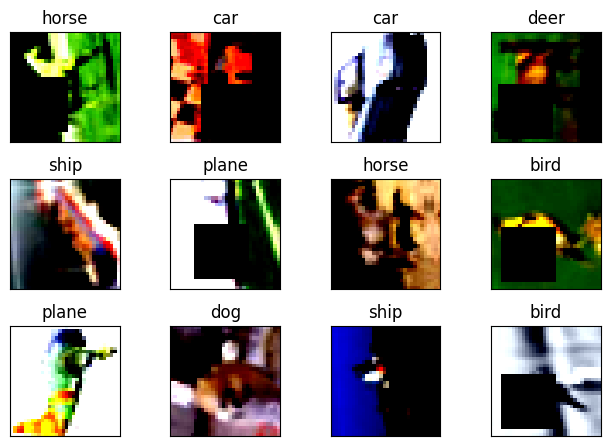

In [13]:
import matplotlib.pyplot as plt
import numpy as np
batch_data, batch_label = next(iter(train_loader))
fig = plt.figure()
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.tight_layout()
    plt.imshow(np.transpose(batch_data[i].numpy(), (2, 1, 0)), cmap='gray')
    plt.title(f'{classes[batch_label[i].item()]}')
    plt.xticks([])
    plt.yticks([])
plt.show()

In [14]:
def calc_activation_shape(dim, ksize, dilation=(1, 1), stride=(1, 1), padding=(0, 0)):
  def shape_each_dim(i):
    odim_i = dim[i] + 2 * padding[i] - dilation[i] * (ksize[i] - 1) - 1
    return (odim_i / stride[i]) + 1
  return shape_each_dim(0), shape_each_dim(1)

def calc_receptive_field(Rin,ksize, stride, Jin, dilation=1):
    new_k = dilation*(ksize - 1) + 1
    #if dilation>1:
    Jnew = Jin*stride
    #else:
    #Jnew = stride*Jin
    return Rin + (new_k-1)*Jin, Jnew

In [58]:
print('******** Block 1 **********')
output_channel_size = calc_activation_shape(dim=(32,32), ksize=(7,7), dilation=(1, 1), stride=(1, 1), padding=(1, 1))
print(f'Output Channel size {output_channel_size}')
output_receptive_field, Jnew = calc_receptive_field(Rin=1 ,ksize=7, stride=1, Jin=1, dilation=1)
print('Receptive Field', output_receptive_field)

output_channel_size = calc_activation_shape(dim=output_channel_size, ksize=(5,5), dilation=(1, 1), stride=(1, 1), padding=(1, 1))
print(f'Output Channel size {output_channel_size}')
output_receptive_field, Jnew = calc_receptive_field(Rin=output_receptive_field ,ksize=5, stride=1,Jin=Jnew, dilation=1)
print('Receptive Field', output_receptive_field)

output_channel_size = calc_activation_shape(dim=output_channel_size, ksize=(3,3), dilation=(2, 2), stride=(1, 1), padding=(1, 1))
print(f'Output Channel size {output_channel_size}')
output_receptive_field, Jnew = calc_receptive_field(Rin=output_receptive_field ,ksize=3, stride=1, Jin=Jnew, dilation=2)
print('Receptive Field', output_receptive_field)

print('******** Block 2 **********', f'Jin {Jnew}')
output_channel_size = calc_activation_shape(dim=output_channel_size, ksize=(3,3), dilation=(1, 1), stride=(1, 1), padding=(1, 1))
print(f'Output Channel size {output_channel_size}')
output_receptive_field, Jnew = calc_receptive_field(Rin=output_receptive_field ,ksize=3, stride=1,Jin=Jnew, dilation=1)
print('Receptive Field', output_receptive_field)

output_channel_size = calc_activation_shape(dim=output_channel_size, ksize=(1,1), dilation=(1, 1), stride=(1, 1), padding=(1, 1))
print(f'Output Channel size {output_channel_size}')
output_receptive_field, Jnew = calc_receptive_field(Rin=output_receptive_field ,ksize=1, stride=1, Jin=Jnew, dilation=1)
print('Receptive Field', output_receptive_field)

output_channel_size = calc_activation_shape(dim=output_channel_size, ksize=(3,3), dilation=(4, 4), stride=(1, 1), padding=(1, 1))
print(f'Output Channel size {output_channel_size}')
output_receptive_field, Jnew = calc_receptive_field(Rin=output_receptive_field ,ksize=3, stride=1, Jin=Jnew, dilation=4)
print('Receptive Field', output_receptive_field)

print('******** Block 3 **********', f'Jin {Jnew}')
output_channel_size = calc_activation_shape(dim=output_channel_size, ksize=(3,3), dilation=(1, 1), stride=(1, 1), padding=(1, 1))
print(f'Output Channel size {output_channel_size}')
output_receptive_field, Jnew = calc_receptive_field(Rin=output_receptive_field ,ksize=3, stride=1,Jin=Jnew, dilation=1)
print('Receptive Field', output_receptive_field)

output_channel_size = calc_activation_shape(dim=output_channel_size, ksize=(1,1), dilation=(1, 1), stride=(1, 1), padding=(1, 1))
print(f'Output Channel size {output_channel_size}')
output_receptive_field, Jnew = calc_receptive_field(Rin=output_receptive_field ,ksize=1, stride=1, Jin=Jnew, dilation=1)
print('Receptive Field', output_receptive_field)

output_channel_size = calc_activation_shape(dim=output_channel_size, ksize=(3,3), dilation=(8, 8), stride=(1, 1), padding=(1, 1))
print(f'Output Channel size {output_channel_size}')
output_receptive_field, Jnew = calc_receptive_field(Rin=output_receptive_field ,ksize=3, stride=1, Jin=Jnew, dilation=8)
print('Receptive Field', output_receptive_field)

print('******** Block 4 **********', f'Jin {Jnew}')
output_channel_size = calc_activation_shape(dim=output_channel_size, ksize=(3,3), dilation=(1, 1), stride=(1, 1), padding=(1, 1))
print(f'Output Channel size {output_channel_size}')
output_receptive_field, Jnew = calc_receptive_field(Rin=output_receptive_field ,ksize=3, stride=1,Jin=Jnew, dilation=1)
print('Receptive Field', output_receptive_field)

output_channel_size = calc_activation_shape(dim=output_channel_size, ksize=(1,1), dilation=(1, 1), stride=(1, 1), padding=(1, 1))
print(f'Output Channel size {output_channel_size}')
output_receptive_field, Jnew = calc_receptive_field(Rin=output_receptive_field ,ksize=1, stride=1, Jin=Jnew, dilation=1)
print('Receptive Field', output_receptive_field)


******** Block 1 **********
Output Channel size (28.0, 28.0)
Receptive Field 7
Output Channel size (26.0, 26.0)
Receptive Field 11
Output Channel size (24.0, 24.0)
Receptive Field 15
******** Block 2 ********** Jin 1
Output Channel size (24.0, 24.0)
Receptive Field 17
Output Channel size (26.0, 26.0)
Receptive Field 17
Output Channel size (20.0, 20.0)
Receptive Field 25
******** Block 3 ********** Jin 1
Output Channel size (20.0, 20.0)
Receptive Field 27
Output Channel size (22.0, 22.0)
Receptive Field 27
Output Channel size (8.0, 8.0)
Receptive Field 43
******** Block 4 ********** Jin 1
Output Channel size (8.0, 8.0)
Receptive Field 45
Output Channel size (10.0, 10.0)
Receptive Field 45


In [63]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Dilated_Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]           2,352
              ReLU-2           [-1, 16, 28, 28]               0
       BatchNorm2d-3           [-1, 16, 28, 28]              32
           Dropout-4           [-1, 16, 28, 28]               0
            Conv2d-5           [-1, 32, 28, 28]           4,608
              ReLU-6           [-1, 32, 28, 28]               0
       BatchNorm2d-7           [-1, 32, 28, 28]              64
           Dropout-8           [-1, 32, 28, 28]               0
            Conv2d-9           [-1, 32, 26, 26]           9,216
             ReLU-10           [-1, 32, 26, 26]               0
      BatchNorm2d-11           [-1, 32, 26, 26]              64
          Dropout-12           [-1, 32, 26, 26]               0
           Conv2d-13           [-1, 32, 26, 26]           9,216
             ReLU-14           [-1, 32,

In [64]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.
    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
#epoch 5  Accuracy=54.67 , 60.59%

In [66]:
model = Dilated_Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)
num_epochs = 65
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}')
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

Epoch 1


Loss=1.534231424331665 Batch_id=97 Accuracy=33.63: 100%|██████████| 98/98 [00:14<00:00,  6.78it/s]



Test set: Average loss: 1.6515, Accuracy: 4098/10000 (40.98%)

Epoch 2


Loss=1.4442251920700073 Batch_id=97 Accuracy=44.78: 100%|██████████| 98/98 [00:14<00:00,  6.73it/s]



Test set: Average loss: 1.4523, Accuracy: 4938/10000 (49.38%)

Epoch 3


Loss=1.438436508178711 Batch_id=97 Accuracy=50.11: 100%|██████████| 98/98 [00:14<00:00,  6.64it/s]



Test set: Average loss: 1.1897, Accuracy: 5701/10000 (57.01%)

Epoch 4


Loss=1.1738317012786865 Batch_id=97 Accuracy=54.41: 100%|██████████| 98/98 [00:14<00:00,  6.55it/s]



Test set: Average loss: 1.1111, Accuracy: 6071/10000 (60.71%)

Epoch 5


Loss=1.109797716140747 Batch_id=97 Accuracy=57.46: 100%|██████████| 98/98 [00:15<00:00,  6.42it/s]



Test set: Average loss: 1.0261, Accuracy: 6420/10000 (64.20%)

Epoch 6


Loss=1.123292088508606 Batch_id=97 Accuracy=60.47: 100%|██████████| 98/98 [00:14<00:00,  6.74it/s]



Test set: Average loss: 0.9099, Accuracy: 6781/10000 (67.81%)

Epoch 7


Loss=1.0355364084243774 Batch_id=97 Accuracy=63.00: 100%|██████████| 98/98 [00:14<00:00,  6.64it/s]



Test set: Average loss: 0.8610, Accuracy: 6990/10000 (69.90%)

Epoch 8


Loss=1.036393165588379 Batch_id=97 Accuracy=64.66: 100%|██████████| 98/98 [00:14<00:00,  6.70it/s]



Test set: Average loss: 0.8396, Accuracy: 7058/10000 (70.58%)

Epoch 9


Loss=0.9046739935874939 Batch_id=97 Accuracy=65.96: 100%|██████████| 98/98 [00:15<00:00,  6.48it/s]



Test set: Average loss: 0.8239, Accuracy: 7149/10000 (71.49%)

Epoch 10


Loss=1.0052107572555542 Batch_id=97 Accuracy=67.09: 100%|██████████| 98/98 [00:15<00:00,  6.52it/s]



Test set: Average loss: 0.7548, Accuracy: 7354/10000 (73.54%)

Epoch 11


Loss=0.9686949849128723 Batch_id=97 Accuracy=68.49: 100%|██████████| 98/98 [00:14<00:00,  6.74it/s]



Test set: Average loss: 0.7168, Accuracy: 7520/10000 (75.20%)

Epoch 12


Loss=0.8044407367706299 Batch_id=97 Accuracy=69.02: 100%|██████████| 98/98 [00:14<00:00,  6.69it/s]



Test set: Average loss: 0.7668, Accuracy: 7384/10000 (73.84%)

Epoch 13


Loss=0.8378484845161438 Batch_id=97 Accuracy=69.81: 100%|██████████| 98/98 [00:14<00:00,  6.79it/s]



Test set: Average loss: 0.6951, Accuracy: 7595/10000 (75.95%)

Epoch 14


Loss=0.8781651854515076 Batch_id=97 Accuracy=70.82: 100%|██████████| 98/98 [00:14<00:00,  6.54it/s]



Test set: Average loss: 0.6963, Accuracy: 7629/10000 (76.29%)

Epoch 15


Loss=0.7704454064369202 Batch_id=97 Accuracy=71.19: 100%|██████████| 98/98 [00:14<00:00,  6.55it/s]



Test set: Average loss: 0.6502, Accuracy: 7773/10000 (77.73%)

Epoch 16


Loss=0.8081290125846863 Batch_id=97 Accuracy=71.73: 100%|██████████| 98/98 [00:14<00:00,  6.62it/s]



Test set: Average loss: 0.6479, Accuracy: 7783/10000 (77.83%)

Epoch 17


Loss=0.8009256720542908 Batch_id=97 Accuracy=72.00: 100%|██████████| 98/98 [00:14<00:00,  6.91it/s]



Test set: Average loss: 0.6484, Accuracy: 7829/10000 (78.29%)

Epoch 18


Loss=0.7660326957702637 Batch_id=97 Accuracy=72.49: 100%|██████████| 98/98 [00:14<00:00,  6.88it/s]



Test set: Average loss: 0.6500, Accuracy: 7814/10000 (78.14%)

Epoch 19


Loss=0.7653737664222717 Batch_id=97 Accuracy=73.02: 100%|██████████| 98/98 [00:14<00:00,  6.92it/s]



Test set: Average loss: 0.6150, Accuracy: 7971/10000 (79.71%)

Epoch 20


Loss=0.8040974140167236 Batch_id=97 Accuracy=73.62: 100%|██████████| 98/98 [00:14<00:00,  6.89it/s]



Test set: Average loss: 0.6415, Accuracy: 7828/10000 (78.28%)

Epoch 21


Loss=0.7234141826629639 Batch_id=97 Accuracy=74.00: 100%|██████████| 98/98 [00:14<00:00,  6.88it/s]



Test set: Average loss: 0.6426, Accuracy: 7841/10000 (78.41%)

Epoch 22


Loss=0.831925630569458 Batch_id=97 Accuracy=74.26: 100%|██████████| 98/98 [00:14<00:00,  6.70it/s]



Test set: Average loss: 0.5970, Accuracy: 7981/10000 (79.81%)

Epoch 23


Loss=0.722855269908905 Batch_id=97 Accuracy=74.53: 100%|██████████| 98/98 [00:14<00:00,  6.61it/s]



Test set: Average loss: 0.6577, Accuracy: 7806/10000 (78.06%)

Epoch 24


Loss=0.6864461898803711 Batch_id=97 Accuracy=74.59: 100%|██████████| 98/98 [00:14<00:00,  6.99it/s]



Test set: Average loss: 0.6148, Accuracy: 7918/10000 (79.18%)

Epoch 25


Loss=0.6699902415275574 Batch_id=97 Accuracy=75.04: 100%|██████████| 98/98 [00:14<00:00,  7.00it/s]



Test set: Average loss: 0.5883, Accuracy: 8002/10000 (80.02%)

Epoch 26


Loss=0.7533020973205566 Batch_id=97 Accuracy=75.61: 100%|██████████| 98/98 [00:13<00:00,  7.06it/s]



Test set: Average loss: 0.6013, Accuracy: 7987/10000 (79.87%)

Epoch 27


Loss=0.7362222075462341 Batch_id=97 Accuracy=75.54: 100%|██████████| 98/98 [00:14<00:00,  6.85it/s]



Test set: Average loss: 0.5982, Accuracy: 7990/10000 (79.90%)

Epoch 28


Loss=0.689212441444397 Batch_id=97 Accuracy=75.89: 100%|██████████| 98/98 [00:14<00:00,  6.82it/s]



Test set: Average loss: 0.5689, Accuracy: 8066/10000 (80.66%)

Epoch 29


Loss=0.6262606382369995 Batch_id=97 Accuracy=76.38: 100%|██████████| 98/98 [00:14<00:00,  6.83it/s]



Test set: Average loss: 0.5697, Accuracy: 8100/10000 (81.00%)

Epoch 30


Loss=0.6779646277427673 Batch_id=97 Accuracy=76.39: 100%|██████████| 98/98 [00:14<00:00,  6.61it/s]



Test set: Average loss: 0.5981, Accuracy: 8013/10000 (80.13%)

Epoch 31


Loss=0.669745683670044 Batch_id=97 Accuracy=76.30: 100%|██████████| 98/98 [00:14<00:00,  6.81it/s]



Test set: Average loss: 0.6022, Accuracy: 8005/10000 (80.05%)

Epoch 32


Loss=0.8133069276809692 Batch_id=97 Accuracy=76.58: 100%|██████████| 98/98 [00:14<00:00,  6.94it/s]



Test set: Average loss: 0.5341, Accuracy: 8183/10000 (81.83%)

Epoch 33


Loss=0.6860213279724121 Batch_id=97 Accuracy=76.67: 100%|██████████| 98/98 [00:14<00:00,  6.94it/s]



Test set: Average loss: 0.5534, Accuracy: 8137/10000 (81.37%)

Epoch 34


Loss=0.6641324758529663 Batch_id=97 Accuracy=77.11: 100%|██████████| 98/98 [00:14<00:00,  6.96it/s]



Test set: Average loss: 0.5458, Accuracy: 8216/10000 (82.16%)

Epoch 35


Loss=0.638272762298584 Batch_id=97 Accuracy=77.21: 100%|██████████| 98/98 [00:14<00:00,  6.90it/s]



Test set: Average loss: 0.5553, Accuracy: 8169/10000 (81.69%)

Epoch 36


Loss=0.6677089333534241 Batch_id=97 Accuracy=77.14: 100%|██████████| 98/98 [00:13<00:00,  7.04it/s]



Test set: Average loss: 0.5487, Accuracy: 8137/10000 (81.37%)

Epoch 37


Loss=0.6509665846824646 Batch_id=97 Accuracy=77.60: 100%|██████████| 98/98 [00:13<00:00,  7.00it/s]



Test set: Average loss: 0.5411, Accuracy: 8198/10000 (81.98%)

Epoch 38


Loss=0.6909192800521851 Batch_id=97 Accuracy=77.42: 100%|██████████| 98/98 [00:14<00:00,  6.80it/s]



Test set: Average loss: 0.5307, Accuracy: 8278/10000 (82.78%)

Epoch 39


Loss=0.5723086595535278 Batch_id=97 Accuracy=78.07: 100%|██████████| 98/98 [00:14<00:00,  6.64it/s]



Test set: Average loss: 0.5458, Accuracy: 8205/10000 (82.05%)

Epoch 40


Loss=0.610863208770752 Batch_id=97 Accuracy=77.68: 100%|██████████| 98/98 [00:14<00:00,  6.98it/s]



Test set: Average loss: 0.5331, Accuracy: 8228/10000 (82.28%)

Epoch 41


Loss=0.6744407415390015 Batch_id=97 Accuracy=78.12: 100%|██████████| 98/98 [00:14<00:00,  6.98it/s]



Test set: Average loss: 0.5297, Accuracy: 8286/10000 (82.86%)

Epoch 42


Loss=0.6789969205856323 Batch_id=97 Accuracy=78.15: 100%|██████████| 98/98 [00:14<00:00,  6.96it/s]



Test set: Average loss: 0.5341, Accuracy: 8193/10000 (81.93%)

Epoch 43


Loss=0.6190624237060547 Batch_id=97 Accuracy=78.29: 100%|██████████| 98/98 [00:14<00:00,  6.94it/s]



Test set: Average loss: 0.5370, Accuracy: 8253/10000 (82.53%)

Epoch 44


Loss=0.6176922917366028 Batch_id=97 Accuracy=78.20: 100%|██████████| 98/98 [00:13<00:00,  7.05it/s]



Test set: Average loss: 0.5286, Accuracy: 8247/10000 (82.47%)

Epoch 45


Loss=0.6286166310310364 Batch_id=97 Accuracy=78.66: 100%|██████████| 98/98 [00:14<00:00,  6.84it/s]



Test set: Average loss: 0.5285, Accuracy: 8285/10000 (82.85%)

Epoch 46


Loss=0.5665826797485352 Batch_id=97 Accuracy=78.60: 100%|██████████| 98/98 [00:13<00:00,  7.06it/s]



Test set: Average loss: 0.5370, Accuracy: 8228/10000 (82.28%)

Epoch 47


Loss=0.6012366414070129 Batch_id=97 Accuracy=78.78: 100%|██████████| 98/98 [00:14<00:00,  6.88it/s]



Test set: Average loss: 0.4903, Accuracy: 8368/10000 (83.68%)

Epoch 48


Loss=0.6096970438957214 Batch_id=97 Accuracy=78.81: 100%|██████████| 98/98 [00:14<00:00,  6.82it/s]



Test set: Average loss: 0.5017, Accuracy: 8336/10000 (83.36%)

Epoch 49


Loss=0.5575509071350098 Batch_id=97 Accuracy=79.18: 100%|██████████| 98/98 [00:14<00:00,  6.73it/s]



Test set: Average loss: 0.5102, Accuracy: 8286/10000 (82.86%)

Epoch 50


Loss=0.5298765897750854 Batch_id=97 Accuracy=79.16: 100%|██████████| 98/98 [00:13<00:00,  7.06it/s]



Test set: Average loss: 0.5144, Accuracy: 8318/10000 (83.18%)

Epoch 51


Loss=0.47869786620140076 Batch_id=97 Accuracy=81.27: 100%|██████████| 98/98 [00:14<00:00,  6.98it/s]



Test set: Average loss: 0.4496, Accuracy: 8511/10000 (85.11%)

Epoch 52


Loss=0.44174739718437195 Batch_id=97 Accuracy=81.96: 100%|██████████| 98/98 [00:13<00:00,  7.03it/s]



Test set: Average loss: 0.4420, Accuracy: 8524/10000 (85.24%)

Epoch 53


Loss=0.4889080822467804 Batch_id=97 Accuracy=82.23: 100%|██████████| 98/98 [00:13<00:00,  7.08it/s]



Test set: Average loss: 0.4444, Accuracy: 8521/10000 (85.21%)

Epoch 54


Loss=0.46436962485313416 Batch_id=97 Accuracy=82.39: 100%|██████████| 98/98 [00:13<00:00,  7.02it/s]



Test set: Average loss: 0.4369, Accuracy: 8552/10000 (85.52%)

Epoch 55


Loss=0.4764350354671478 Batch_id=97 Accuracy=82.59: 100%|██████████| 98/98 [00:13<00:00,  7.04it/s]



Test set: Average loss: 0.4389, Accuracy: 8532/10000 (85.32%)

Epoch 56


Loss=0.4823492467403412 Batch_id=97 Accuracy=82.76: 100%|██████████| 98/98 [00:13<00:00,  7.07it/s]



Test set: Average loss: 0.4362, Accuracy: 8560/10000 (85.60%)

Epoch 57


Loss=0.4827774465084076 Batch_id=97 Accuracy=82.71: 100%|██████████| 98/98 [00:14<00:00,  6.93it/s]



Test set: Average loss: 0.4430, Accuracy: 8533/10000 (85.33%)

Epoch 58


Loss=0.46571218967437744 Batch_id=97 Accuracy=82.78: 100%|██████████| 98/98 [00:14<00:00,  6.85it/s]



Test set: Average loss: 0.4387, Accuracy: 8553/10000 (85.53%)

Epoch 59


Loss=0.5312091112136841 Batch_id=97 Accuracy=82.65: 100%|██████████| 98/98 [00:14<00:00,  6.73it/s]



Test set: Average loss: 0.4356, Accuracy: 8572/10000 (85.72%)

Epoch 60


Loss=0.5170820355415344 Batch_id=97 Accuracy=82.68: 100%|██████████| 98/98 [00:13<00:00,  7.05it/s]



Test set: Average loss: 0.4361, Accuracy: 8549/10000 (85.49%)

Epoch 61


Loss=0.4637870788574219 Batch_id=97 Accuracy=83.24: 100%|██████████| 98/98 [00:14<00:00,  6.97it/s]



Test set: Average loss: 0.4383, Accuracy: 8563/10000 (85.63%)

Epoch 62


Loss=0.5535367131233215 Batch_id=97 Accuracy=83.02: 100%|██████████| 98/98 [00:13<00:00,  7.00it/s]



Test set: Average loss: 0.4295, Accuracy: 8567/10000 (85.67%)

Epoch 63


Loss=0.5828446745872498 Batch_id=97 Accuracy=83.02: 100%|██████████| 98/98 [00:13<00:00,  7.02it/s]



Test set: Average loss: 0.4329, Accuracy: 8590/10000 (85.90%)

Epoch 64


Loss=0.514827311038971 Batch_id=97 Accuracy=82.92: 100%|██████████| 98/98 [00:13<00:00,  7.02it/s]



Test set: Average loss: 0.4360, Accuracy: 8551/10000 (85.51%)

Epoch 65


Loss=0.4464647173881531 Batch_id=97 Accuracy=83.13: 100%|██████████| 98/98 [00:14<00:00,  6.88it/s]



Test set: Average loss: 0.4314, Accuracy: 8570/10000 (85.70%)



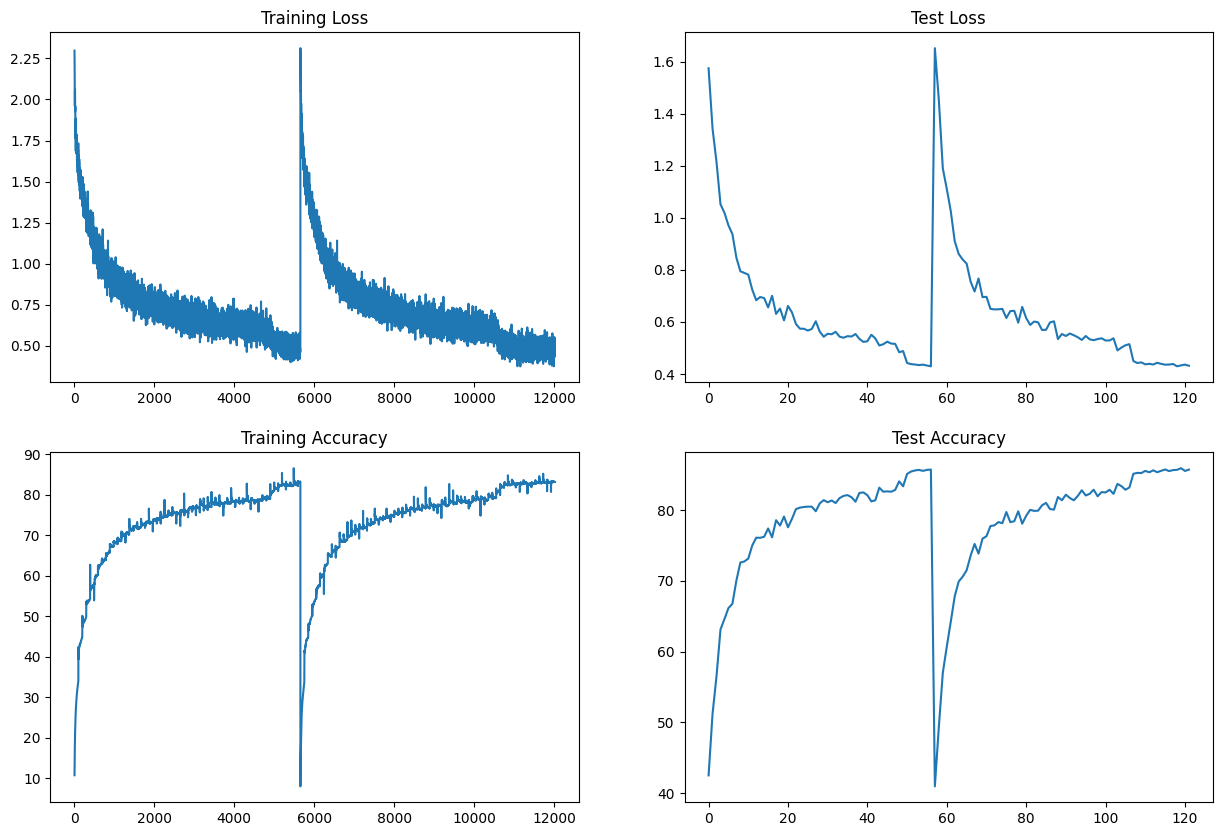

In [68]:
train_losses_lst = [t_items.item() for t_items in train_losses]
plot_performance(train_losses_lst, train_acc, test_losses, test_acc)

In [69]:
model.eval()
test_loss = 0
correct = 0
i =0
misclassified_dict = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        t = pred.eq(target.view_as(pred)).view(-1, target.size(0))
        t = t.cpu().numpy().reshape(-1)
        for ind,val in enumerate(t):
          if not val :
            temp_dict = {}
            temp_dict['data'] = data[ind].cpu().numpy()
            temp_dict['target'] = target[ind]
            temp_dict['pred'] = pred[ind]
            misclassified_dict.append(temp_dict)

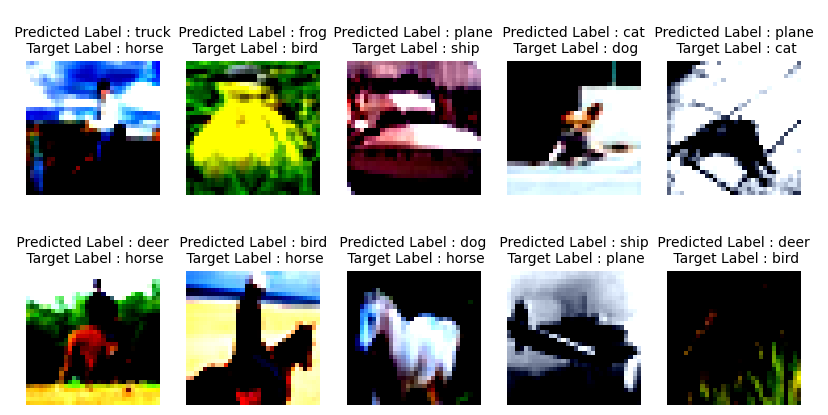

In [70]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
display_images = misclassified_dict[:10]
index = 0
fig = plt.figure(figsize=(10,5))
for img in display_images:
    image = img['data']
    pred = classes[img['pred']]
    actual = classes[img['target']]
    ax = fig.add_subplot(2, 5, index+1)
    ax.axis('off')
    ax.set_title(f'\n Predicted Label : {pred} \n Target Label : {actual}',fontsize=10)
    ax.imshow(np.transpose(image, (1, 2, 0)))
    index = index + 1
plt.show()